In [1]:
from streamlit_app.src.load_dataset import load_dataset
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from streamlit_app.src.preprocessing import LoadAndPrepareData
from streamlit_app.src.models.LogReg import LogisticModel
import numpy as np
from streamlit_app import config

2025-10-03 03:27:24.001523: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-03 03:27:24.073556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-03 03:27:25.955238: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# import yfinance as yf
horizon = "2m" # '60m', '2m'
window_size = 7
# df_ = yf.download(tickers="BTC-USD", period="max", interval=horizon)
# df_.shape
# df_

In [24]:

raw_df = load_dataset(interval=horizon)

/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/my_project/streamlit_app/src/load_dataset.py:67: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


In [25]:
raw_df.shape

(24651, 5)

In [26]:
prp = LoadAndPrepareData(raw_df, interval=horizon, LoadAndPrepareData_path=config.LOAD_AND_PREPARE_DIR, window_size=window_size)
df_featured= prp.extract_all_features()

/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/my_project/streamlit_app/src/featuer_extractors.py:222: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coeffs, _ = pywt.cwt(df2[col].fillna(method='ffill').values, scales, wavelet)


In [27]:
numpy_data, targets_cls, targets_reg = prp.build_numpy_inputs_targets_data(cls_threshold=0.0002)
gen_cls, gen_reg = prp.build_windowed_data()
splited_data = prp.split_data()
ml_data_1h_cls = prp.splited_data["classification"]
ml_data_1h_reg = prp.splited_data["regression"]
prp.save()

In [28]:
len(numpy_data)

24451

In [3]:
prv_prp = LoadAndPrepareData.load(interval=horizon, 
                                  window_size=window_size, 
                                  LoadAndPrepareData_path=config.LOAD_AND_PREPARE_DIR)
dir(prv_prp)

Something went wrong when trying to dump the oject, Ran out of input


['__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [30]:
# ---------------------------------------------------------
# Param grids
# ---------------------------------------------------------
from scipy.stats import loguniform
CLS_PARAM_GRIDS = {
    "CLogReg": {
        "C": [0.1, 1, 10],
        "solver": ["lbfgs", "saga"]
    },
    "rf": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5]
    },
    "lgbm": {
    "num_leaves": [15, 31, 63, 127],
    "max_depth": [-1, 5, 10, 15],
    "learning_rate": [0.005, 0.01, 0.05, 0.1],
    "n_estimators": [100, 300, 500, 1000],
    # "subsample": [0.6, 0.8, 1.0],
    # "colsample_bytree": [0.6, 0.8, 1.0],
    # "reg_alpha": [0, 0.1, 0.5],
    # "reg_lambda": [0, 0.1, 0.5]
    },
    "svm":{
            "C": loguniform(1e-3, 1e2),
            "kernel": ["linear", "rbf", "poly"],
            "gamma": ["scale", "auto"]
        }
}

REG_PARAM_GRIDS = {
    "ridge": {
        "alpha": [0.1, 1, 10],
        "solver": ["auto", "svd", "lsqr"]
    },
    "rf": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, None],
        "min_samples_split": [2, 5]
    },
    "lgbm": {
        "num_leaves": [31, 63],
        "learning_rate": [0.05, 0.1],
        "n_estimators": [100, 200]
    },
    "svm":{
            "C": loguniform(1e-3, 1e2),
            "kernel": ["linear", "rbf", "poly"],
            "gamma": ["scale", "auto"]
        }
}


In [31]:
loguniform(1e-3, 1e2)

In [32]:
x_train_cls = ml_data_1h_cls["x_train"]
x_train_cls = np.concatenate([x_train_cls, ml_data_1h_cls["x_val"]], axis=0)

y_train_cls = ml_data_1h_cls['y_train']
y_train_cls = np.concatenate([y_train_cls, ml_data_1h_cls['y_val']], axis=0)

y_test_cls = ml_data_1h_cls["y_test"]
x_test_cls = ml_data_1h_cls["x_test"]

# x_train_cls.shape, y_train_cls.shape, x_test_cls.shape, y_test_cls.shape

In [13]:
logReg_model = LogisticModel(horizon=horizon, window_size=window_size, save_dir=config.TRAINED_MODELS_DIR)
logReg_model.tune_hyperparameters(x_train_cls, y_train_cls, CLS_PARAM_GRIDS['CLogReg'])

/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomia

{'solver': 'lbfgs', 'C': 0.1}

In [14]:

logReg_model.evaluate(x_test_cls, y_test_cls, n_classes=3, task='classification')

{'accuracy': 0.40555555555555556,
 'f1': 0.2542535645788846,
 'auc': 0.5097839834287639,
 'confusion_matrix': array([[  8, 301,   3],
        [  4, 425,   7],
        [  6, 321,   5]]),
 'train_date': '2025-10-02_01:31'}

In [15]:
logReg_model.save()

In [15]:
logReg_model_ = LogisticModel.load(horizon="2m", name=config.MODELS_NAMES["logistic regression"], window_size=7)
logReg_model_.evaluate()

TypeError: Model.evaluate() missing 2 required positional arguments: 'X' and 'y'

In [14]:
for i in range(len(x_test_cls)):
    print(logReg_model.predict([x_train_cls[i]]), y_train_cls[i])

[1] 1
[1] 1
[0] 0
[0] 2
[0] 2
[0] 2
[0] 1
[0] 1
[2] 0
[0] 2
[0] 0
[1] 0
[0] 1
[0] 0
[0] 0
[0] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 0
[1] 2
[1] 0
[1] 2
[1] 0
[1] 1
[1] 0
[1] 0
[1] 1
[1] 0
[1] 1
[1] 2
[1] 1
[1] 1
[1] 1
[1] 0
[1] 0
[1] 2
[1] 2
[0] 0
[0] 2
[0] 1
[1] 0
[1] 1
[1] 2
[1] 1
[1] 2
[0] 0
[0] 1
[0] 0
[2] 2
[1] 2
[1] 0
[0] 2
[0] 0
[0] 1
[0] 0
[0] 0
[0] 1
[0] 2
[0] 0
[0] 1
[0] 0
[0] 0
[0] 1
[0] 1
[1] 1
[1] 1
[1] 0
[1] 1
[0] 2
[0] 2
[2] 1
[1] 2
[1] 0
[1] 2
[1] 2
[1] 2
[1] 2
[1] 0
[1] 2
[0] 0
[1] 2
[1] 0
[1] 1
[1] 0
[1] 1
[0] 2
[0] 1
[0] 2
[1] 2
[1] 2
[1] 0
[1] 1
[1] 1
[1] 0
[0] 1
[1] 1
[0] 2
[1] 1
[1] 2
[1] 2
[1] 1
[1] 1
[0] 0
[1] 1
[0] 0
[1] 2
[1] 1
[1] 0
[1] 2
[1] 1
[1] 1
[1] 0
[1] 2
[0] 1
[0] 1
[2] 2
[0] 1
[1] 1
[1] 1
[1] 1
[1] 0
[1] 1
[1] 1
[1] 2
[1] 2
[1] 2
[1] 0
[1] 1
[1] 0
[1] 1
[1] 2
[1] 2
[1] 1
[1] 1
[1] 0
[1] 1
[0] 0
[0] 1
[2] 1
[0] 2
[1] 1
[1] 0
[0] 1
[1] 1
[1] 0
[1] 1
[1] 2
[1] 2
[1] 2
[1] 2
[1] 0
[1] 0
[1] 1
[0] 2
[1] 1
[0] 2
[1] 2
[1] 0
[1] 2
[1] 2
[1] 2
[1] 1
[1] 2
[1] 1
[1] 

In [12]:
from streamlit_app.src.models.CRandomForest import RandomForestClsModel

clsRF_model = RandomForestClsModel(horizon=horizon, window_size=window_size, save_dir = config.TRAINED_MODELS_DIR)
clsRF_model.tune_hyperparameters(x_train_cls, y_train_cls, CLS_PARAM_GRIDS['rf'])

/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 5}

In [13]:
clsRF_model.evaluate(x_test_cls, y_test_cls, n_classes=3, task='classification')

{'accuracy': 0.4168207024029575,
 'f1': 0.307405723492977,
 'auc': 0.5589933953480782,
 'confusion_matrix': array([[ 63, 244,   0],
        [ 49, 388,   0],
        [ 65, 273,   0]]),
 'train_date': ''}

In [14]:
clsRF_model.save()

In [17]:
from streamlit_app.src.models.CLGBM import LightGBMClsModel
clsLightGBM_model = LightGBMClsModel(horizon=horizon, window_size=window_size, save_dir = config.TRAINED_MODELS_DIR)

In [19]:
params_clsLightGBM_model ={
"num_leaves": 15,
"max_depth": 5,
"learning_rate": 0.01,
"n_estimators": 300,
"subsample":0.6,
"colsample_bytree": 0.6,
"reg_alpha": 0.5,
"reg_lambda":  0.5
}
clsLightGBM_model.build_model(params_clsLightGBM_model)
clsLightGBM_model.train(x_train_cls, y_train_cls)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 23182, number of used features: 175
[LightGBM] [Info] Start training from score -1.422755
[LightGBM] [Info] Start training from score -0.652239
[LightGBM] [Info] Start training from score -1.435179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [17]:
clsLightGBM_model.tune_hyperparameters(x_train_cls, y_train_cls, CLS_PARAM_GRIDS['lgbm'], n_iter=3)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15299, number of used features: 175
[LightGBM] [Info] Start training from score -1.427323
[LightGBM] [Info] Start training from score -0.648221
[LightGBM] [Info] Start training from score -1.439382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15299, number of used features: 175
[LightGBM] [Info] Start training from score -1.427323
[LightGBM] [Info] Start training from score -0.648096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190305 seconds.
You can set `force_col_wise=true` to remove 

/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15300, number of used features: 175
[LightGBM] [Info] Start training from score -1.427116
[LightGBM] [Info] Start training from score -0.648286
[LightGBM] [Info] Start training from score -1.439447


/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


KeyboardInterrupt: 

In [20]:
clsLightGBM_model.evaluate(x_test_cls, y_test_cls, n_classes=3, task='classification')

/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


{'accuracy': 0.43366880146386094,
 'f1': 0.3373289498803448,
 'auc': 0.5483745135951329,
 'confusion_matrix': array([[ 36, 243,  20],
        [ 36, 418,  18],
        [ 34, 268,  20]]),
 'train_date': '2025-10-02_11:43'}

In [21]:
clsLightGBM_model.save()

In [15]:
from streamlit_app.src.models.RRidgeReg import RidgeRegModel

regRidgeReg_model =  RidgeRegModel(horizon=horizon, window_size=window_size, save_dir = config.TRAINED_MODELS_DIR)



In [33]:
x_train_reg = ml_data_1h_reg["x_train"]
x_train_reg = np.concatenate([x_train_reg, ml_data_1h_reg["x_val"]], axis=0)

y_train_reg = ml_data_1h_reg['y_train']
y_train_reg = np.concatenate([y_train_reg, ml_data_1h_reg['y_val']], axis=0)

y_test_reg = ml_data_1h_reg["y_test"]
x_test_reg = ml_data_1h_reg["x_test"]


In [38]:
prp.target_reg[:200]

array([ 1.59019047e-05,  1.22930996e-03,  6.98574589e-04, -3.98191229e-05,
       -1.20801397e-04, -3.88208389e-04,  3.66574971e-04,  2.10765422e-04,
        2.03348981e-04, -2.75929307e-05,  1.53822635e-04, -2.58857646e-03,
        1.31909512e-03, -3.56224718e-04, -1.15672437e-03,  1.81466461e-04,
       -2.57709092e-04, -2.97595807e-03, -2.76342873e-04, -1.25350559e-03,
       -2.72946083e-04, -3.86877855e-04, -1.04123803e-03, -1.02232568e-03,
        3.55423464e-04, -4.51515132e-04,  1.51072589e-03, -1.07863419e-03,
       -1.87519331e-04, -3.61313120e-04, -2.45795890e-04,  1.44434573e-04,
       -5.03199285e-04, -5.24489006e-05,  2.59378752e-04, -4.37100091e-05,
       -1.97712314e-04, -7.59444096e-05, -3.49489593e-04, -1.06427091e-03,
        2.51736817e-03,  7.19806248e-04, -1.35414137e-03,  4.34233925e-04,
       -1.47868036e-04, -1.42945400e-03,  8.98446402e-05,  7.37912056e-04,
        1.64277086e-04,  2.88962832e-04, -6.72554632e-04, -1.37504336e-04,
       -4.63977061e-04,  

In [63]:
train_startIndex = np.argwhere(prp.target_reg == y_train_reg[0])
test_startIndex = np.argwhere(prp.target_reg == y_test_reg[0])
train_startIndex, test_startIndex, len(prp.target_reg)
# prp.input_data_dateTime[train_startIndex[0][0]: test_startIndex[0][0]]

(array([[7]]), array([[23350]]), 24451)

In [49]:
np.argwhere(prp.target_reg == y_test_reg[0])

array([[23350]])

In [43]:
prp.target_reg[7]

np.float64(0.00021076542234250149)

In [37]:
y_train_reg[:10]

array([ 2.10765422e-04,  2.03348981e-04, -2.75929307e-05,  1.53822635e-04,
       -2.58857646e-03,  1.31909512e-03, -3.56224718e-04, -1.15672437e-03,
        1.81466461e-04, -2.57709092e-04])

In [17]:
regRidgeReg_model.tune_hyperparameters(x_train_reg, y_train_reg, REG_PARAM_GRIDS['ridge'], n_iter=10)

/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.50768e-27): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.71809e-27): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: I

{'solver': 'lsqr', 'alpha': 0.1}

In [19]:
regRidgeReg_model_ = RidgeRegModel.load(horizon=horizon, window_size=window_size,name=config.MODELS_NAMES["Ridge Regression"])

In [20]:
regRidgeReg_model_.evaluate(x_test_reg, y_test_reg, n_classes=3, task="regression")

{'rmse': 2.660875958884365e-07,
 'mae': 0.000360285371554199,
 'range': np.float64(0.004834318789478329),
 'train_date': '2025-10-01_14:49'}

In [21]:
regRidgeReg_model.evaluate(x_test_reg, y_test_reg, n_classes=3, task="regression")

{'rmse': 2.6609287714440173e-07,
 'mae': 0.0003603406162317371,
 'range': np.float64(0.004834318789478329),
 'train_date': '2025-10-01_16:02'}

In [ ]:
regRidgeReg_model.save()

In [47]:
from math import floor, ceil
prp.input_data_dateTime.shape,\
prp.input_data_dateTime[:ceil(.85*prp.input_data_dateTime.shape[0])].shape, \
y_train_reg.shape

((23681,), (20129,), (22608,))

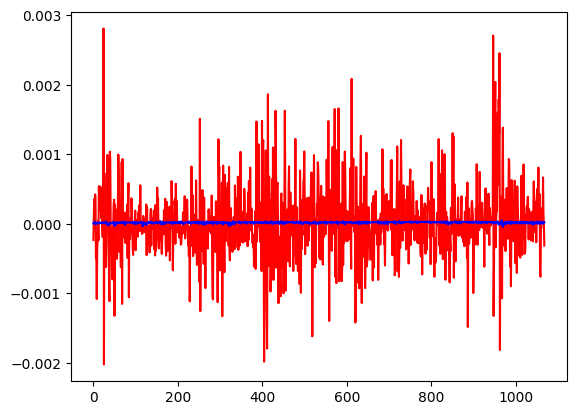

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(len(y_test_reg))
y_pred = regRidgeReg_model.predict(x_test_reg)
plt.plot(x, y_test_reg, color='r')
plt.plot(x, y_pred, color="b")

In [30]:
import plotly.express as px
import pandas as pd

def plot_regression_series(y_test, y_pred, title="Regression Series Comparison"):
    df = pd.DataFrame({
        "Index": range(len(y_test)),
        "True": y_test,
        "Pred": y_pred
    })
    fig = px.line(df, x="Index", y=["True", "Pred"], 
                  labels={"value": "Target"},
                  title=title)
    return fig

In [35]:
y_test_reg_pred = regRidgeReg_model.predict(x_test_reg)
plot_regression_series(y_test_reg, y_test_reg_pred)

In [34]:
y_trian_reg_pred = regRidgeReg_model.predict(x_train_reg)
plot_regression_series(y_train_reg,y_trian_reg_pred)

In [33]:
from streamlit_app.src.models.RRandomForest import RandomForestRegModel

regRandomForest_model = RandomForestRegModel(horizon=horizon, window_size=window_size, save_dir = config.TRAINED_MODELS_DIR)
regRandomForest_model.tune_hyperparameters(x_train_reg, y_train_reg, REG_PARAM_GRIDS['rf'], n_iter=5)

{'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5}

In [36]:
regRandomForest_model.evaluate(x_test_reg, y_test_reg, n_classes=3, task="regression")

{'rmse': 2.6765914904805804e-07,
 'mae': 0.0003634144727955994,
 'range': np.float64(0.004834318789478329),
 'train_date': '2025-10-01_16:08'}

In [ ]:
regRandomForest_model.save()
y_testـpred = regRandomForest_model.predict(x_test_reg)
plot_regression_series(y_test_reg,y_testـpred)

In [42]:
y_trian_reg_pred = regRandomForest_model.predict(x_train_reg)
plot_regression_series(y_train_reg,y_trian_reg_pred)

In [44]:
from streamlit_app.src.models.RLGBM import LightGBMRegModel

regLGBM_model = LightGBMRegModel(horizon=horizon, window_size=window_size, save_dir = config.TRAINED_MODELS_DIR)
regLGBM_model.tune_hyperparameters(x_train_reg, y_train_reg, REG_PARAM_GRIDS['lgbm'], n_iter=5)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15098, number of used features: 175
[LightGBM] [Info] Start training from score 0.000001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15098, number of used features: 175
[LightGBM] [Info] Start training from score 0.000003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15098, number of used features: 175
[LightGBM] [Info] Sta

/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15098, number of used features: 175
[LightGBM] [Info] Start training from score 0.000003


/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15098, number of used features: 175
[LightGBM] [Info] Start training from score 0.000001


/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15098, number of used features: 175
[LightGBM] [Info] Start training from score -0.000001


/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.232643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15098, number of used features: 175
[LightGBM] [Info] Start training from score 0.000003


/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15098, number of used features: 175
[LightGBM] [Info] Start training from score 0.000001


/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15098, number of used features: 175
[LightGBM] [Info] Start training from score -0.000001


/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 15098, number of used features: 175
[LightGBM] [Info] Start training from score 0.000003


/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44625
[LightGBM] [Info] Number of data points in the train set: 22647, number of used features: 175
[LightGBM] [Info] Start training from score 0.000001


{'num_leaves': 31, 'n_estimators': 100, 'learning_rate': 0.05}

In [45]:
regLGBM_model.evaluate(x_test_reg, y_test_reg, n_classes=3, task="regression")

/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



{'rmse': 2.7004880739803304e-07,
 'mae': 0.00036269628474241094,
 'range': np.float64(0.004834318789478329),
 'train_date': '2025-10-01_18:08'}

In [46]:
regLGBM_model.save()
y_testـpred = regLGBM_model.predict(x_test_reg)
plot_regression_series(y_test_reg,y_testـpred)

/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



In [48]:
y_trian_reg_pred = regLGBM_model.predict(x_train_reg)
plot_regression_series(y_train_reg,y_trian_reg_pred)

/home/arman/Desktop/prioritized-books/data-analytics/final-project/2-bit-pred/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

